# Shallow Decoder: super-resolution imaging using sparse sensor
This is the example of reconstructing a shallow decoder to reconstruct the Sea Surface Temperature 

In [2]:
!pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install wget
!pip3 install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=639585f7d4c3431e4e81db3aef4f761aaf57a74dd05917b963568f0d10cbfd12
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 15.2 MB/s 
     |████████████████████████████████| 125 kB 75.9 MB/s 
     |████████████████████████████████| 512 kB 70.8 MB/s 
     |████████████████████████████████| 87 kB 8.7 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=1d97022fd979b35b0a7c16155e4df47a84bb6e561052

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import torch
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import Flatten, Sequential, Linear, Softmax, BatchNorm1d, Identity

import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import netCDF4 as nc
masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.1)

In [4]:
print(torch.__version__)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(torch.device)
# print(torch.cuda.get_device_name(0))

1.12.1+cu113
1.12.1+cu113
<class 'torch.device'>


## download data and land mask

The data is a weekly measure of the sea surface temperature from 1990 until present, provided by NOAA.

The mask data masks out the continents.

The data comes in as NetCDF files.

In [5]:
import wget
wget.download("https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/sst.wkmean.1990-present.nc")
wget.download("https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/lsmask.nc")

'lsmask.nc'

In [6]:
## the weekly mean sea surface temperature and land mask could be downloaded at 
## https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html
## sst.wkmean.1990-present.nc

d = nc.Dataset("./sst.wkmean.1990-present.nc")
data = d['sst'][:1400, :, :]

l = nc.Dataset("./lsmask.nc")
mask = l['mask'][0, :, :]

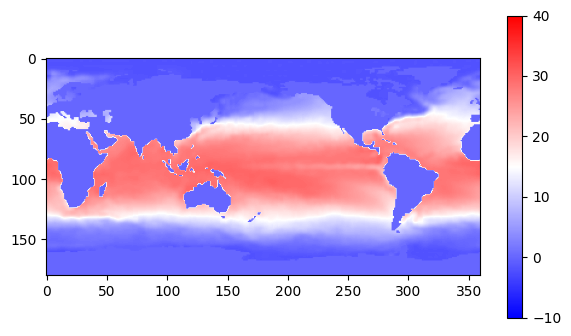

In [9]:
plt.figure(figsize = (7, 4), dpi = 100)
plt.imshow(data[220, :, :]*mask, cmap = masked_cmap, vmin = -10, vmax = 40)
plt.colorbar()

## preprocessing data

The data gets transformed from an image (2D array) into a flat vector (1D array)

In [10]:
raw = np.zeros([1400, 44219])
idx_r, idx_c = np.where(np.array(mask.astype('int'))>0)
for i in range(1400):
    raw[i, :] = np.array(data[i, idx_r, idx_c]).flatten()
print(raw.shape)

(1400, 44219)


Transform data into a Pytorch Dataset

In [11]:
class SeaTempDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, outputs):
        'Initialization'
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.outputs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.inputs[index, :]
        y = self.outputs[index, :]

        return X, y

# Model design


Design a simple encoder-decoder with 3 hidden linear layers.

In [12]:
class SDN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ln1 = Linear(2000, 350) # first layer: the encoder
        self.ln2 = Linear(350, 400) # first layer of the decoder
        self.ln3 = Linear(400, 44219) # second layer of the decoder decoder layer
        self.bn1 = BatchNorm1d(350)
        self.bn2 = BatchNorm1d(400)
        self.activate = torch.relu # activation function
        
    def forward(self, x):
        x = x.float()
        x = self.bn1(self.activate(self.ln1(x))) # feed data through the first layer of encoder
        x = self.bn2(self.activate(self.ln2(x))) # feed data into the second layer of encoder
        x = self.ln3(x) # feed data into decoder
        return x

Define model, and put the model on the device.

In [18]:
model = SDN()
# device = torch.device('cuda')
# model.to(device);

# Prepare data for training

In [14]:
batch_size = 16

## select 1000 snapshots as training set
train_index = np.random.choice(np.arange(1400), 1000, replace = False)

## the rest as validation set
val_index = np.setdiff1d(np.arange(1400), train_index)

## randomly select 2000 sensors as input
input_index = np.random.choice(np.arange(44219), 2000, replace = False)

# 
train_data_output = raw[train_index, :]
train_data_input = train_data_output[:, input_index]

val_data_output = raw[val_index, :]
val_data_input = val_data_output[:, input_index]

# 
train_dataset = SeaTempDataset(train_data_input, train_data_output)
val_dataset = SeaTempDataset(val_data_input, val_data_output)

## put data into DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=5)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=5)

Define loss function: mean square error of each of the element of the vector. PyTorch refers to it as the "Forbius norm".




In [20]:

def loss_fn(y_pred, y_true):
    mis = torch.norm(y_pred - y_true, dim = 1)
    mis /= torch.norm(y_true, dim = 1)
    mis = torch.mean(mis)
    return mis

In [25]:
nsensor = 2000
n_mute_sensors = np.array([0, 1000, 1500, 1750, 1900, 1955, 1965, 1972, 1978, 1984, 
                      1987, 1990, 1992, 1994, 1996, 1997, 1998, 1999])
n_sensors = nsensor - n_mute_sensors

val_losses = {}
for experiment in range(30):
    print(f"test {experiment}")
    mute_sensor = {}
    val_losses[experiment] = []
    
    for nmask in n_mute_sensors:
        sparsity = nmask / nsensor
        print("sparsity %.3f%%"  % (sparsity*100))
        model = SDN()
        # device = torch.device('cuda')
        # model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

        if nmask > 0:
            idx = rms.argsort()[:nmask]
            mask = torch.Tensor(np.ones([350, 2000]))#.to(device)
            mask[:, idx] = 0
            mute_sensor[nmask] = idx
            print(f"pruning {len(idx)} sensors")
            torch.nn.utils.prune.custom_from_mask(model.ln1, name="weight", mask = mask)
        else:
            print("initial model. no pruning")

        patient = 5
        trigger = 0
        min_val_loss = 999999
        for t in range(50):
#             print(f"Epoch {t+1}\n-------------------------------")
            ## train
            model.train()
            train_loss = 0
            for batch_id, batch in enumerate(train_loader): # loop though training data
                pred = model(batch[0])#.to(device)
                loss = loss_fn(pred, batch[1])#.to(device)
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            ## validate
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_id, batch in enumerate(val_loader): # loop through validation data
                    pred = model(batch[0])#.to(device)
                    loss = loss_fn(pred, batch[1])#.to(device)
                    val_loss += loss.item()
            val_loss /= len(val_loader)

#             print("%.4f, %.4f | patient %d"  % (train_loss, val_loss, trigger + 1))
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                trigger = 0
            else:
                trigger += 1
                if trigger == patient:
                    val_losses[experiment].append(min_val_loss)
                    print("Early stop reached. Break.")
                    break

        weight = model.ln1.weight.detach().cpu().numpy()
        rms = np.sqrt(np.mean(weight**2, axis = 0))

test 0
sparsity 0.000%
initial model. no pruning
Early stop reached. Break.
sparsity 50.000%
pruning 1000 sensors
Early stop reached. Break.
sparsity 75.000%
pruning 1500 sensors
Early stop reached. Break.
sparsity 87.500%
pruning 1750 sensors
Early stop reached. Break.
sparsity 95.000%
pruning 1900 sensors
Early stop reached. Break.
sparsity 97.750%
pruning 1955 sensors
Early stop reached. Break.
sparsity 98.250%
pruning 1965 sensors
Early stop reached. Break.
sparsity 98.600%
pruning 1972 sensors


KeyboardInterrupt: ignored

In [ ]:
record = np.array(list(val_losses.values())[:-1])
plt.errorbar(n_sensors, np.mean(record, axis = 0))
plt.xlabel("Num Sensors")
plt.ylabel("Reconstruction Error")
plt.yscale('log')
plt.xlim([0, 50])

NameError: ignored